# Model Selection and Evaluation
By: Prajwal Brijesh Ainapur

This notebook covers model training, selection and evaluation for all the models as mentioned in the thesis for Dataset-1

In [1]:
#Importing Libraries
from collections import Counter
from imblearn.combine import SMOTEENN
from pycaret import classification, clustering
from pycaret.classification import *
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix, recall_score
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import seaborn as sns
import pycaret
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/home/prajwal_brijesh_ainapur/upgradSubmissions/MS_PGM/bank-additional/bank-additional-full.csv')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


As per the dataset description, the duration column is added only after the call is made with the customer and thus, this information is not available well in advance. Thus we proceed to remove this column in order to create a realistic prediction model.

In [4]:
df = df.drop(columns = ['duration'], axis = 1)
df.shape

(41188, 20)

In [5]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(41188, 20)
(39404, 20)


In [6]:
#Creating few user defined functions to make it easier for implementing lots of models

def getSampled(x, y, tmp):
    
    _x, _y = tmp().fit_resample(x, y)
    counter= Counter(_y)
    print(counter)
    
    return _x, _y

def trainPredict(modelName):

    model = create_model(modelName)
    return model


def plotModel(fittedModel, xTest, yTest, title = None):    
    
    model_final = finalize_model(fittedModel)

    y_pred = predict_model(model_final, data = xTest)

    cmat = confusion_matrix(yTest, y_pred.Label)
    print(cmat)
    trec = recall_score(yTest, y_pred.Label)
    print(trec)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTest, y_pred.Label)
    roc_auc = (metrics.auc(fpr, tpr))

    plt.title('Receiver Operating Characteristic' + str(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [7]:
X = df.drop(columns = ['y'], axis = 1)
y = df['y']

Xd = pd.get_dummies(X, drop_first = True)
Xd.shape

(39404, 52)

In [8]:
y = y.replace('no', 0)
y = y.replace('yes', 1)
counter = Counter(y)
print(counter)

Counter({0: 34806, 1: 4598})


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xd, y, stratify = y, test_size = 0.25)

In [10]:
X_trains, y_train1 = getSampled(X_train, y_train, SMOTEENN)

Counter({1: 25117, 0: 15634})


In [11]:
X_train1 = X_trains[['default_yes', 'contact_telephone', 'poutcome_nonexistent', 'poutcome_success', 
                'job_student', 'job_retired', 'marital_unknown', 'education_basic.9y', 'education_basic.6y', 
                'cons.price.idx', 'campaign']]
X_train1.columns

Index(['default_yes', 'contact_telephone', 'poutcome_nonexistent',
       'poutcome_success', 'job_student', 'job_retired', 'marital_unknown',
       'education_basic.9y', 'education_basic.6y', 'cons.price.idx',
       'campaign'],
      dtype='object')

In [12]:
df_tmp = pd.concat([X_train1, y_train1], axis = 1)
classification_setup = classification.setup(data= df_tmp, target='y', fix_imbalance = False)

def trainPlotWrapper(modelName):
    modelL = trainPredict(modelName)
    plotModel(modelL, X_test, y_test)
#     print(modelL)
    return modelL

def TunePlotWrapper(modelL):
    tunedModelL = tune_model(modelL, optimize = 'AUC')
    plotModel(tunedModelL, X_test, y_test)
    print(modelL, '\n', tunedModelL)
#     return modelL, tunedModelL

,Description,Value
0,session_id,7214
1,Target,y
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(40751, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.8772,0.7660,0.8570,0.8089,0.5454,0.5503
1,0.7978,0.8877,0.7774,0.8793,0.8252,0.5874,0.5937
2,0.8069,0.8982,0.8116,0.8655,0.8377,0.5999,0.6018
3,0.7869,0.8761,0.7865,0.8548,0.8193,0.5607,0.5636
4,0.7939,0.8857,0.7825,0.8688,0.8234,0.5776,0.5821
5,0.7956,0.8846,0.7888,0.8665,0.8258,0.5798,0.5835
6,0.8061,0.8937,0.7978,0.8753,0.8348,0.6014,0.6052
7,0.7868,0.8777,0.7841,0.8565,0.8187,0.5612,0.5644
8,0.7970,0.8876,0.7933,0.8649,0.8275,0.5819,0.5852
9,0.8029,0.8853,0.8132,0.8583,0.8352,0.5906,0.5920


[[6283 2418]
 [ 351  799]]
0.6947826086956522


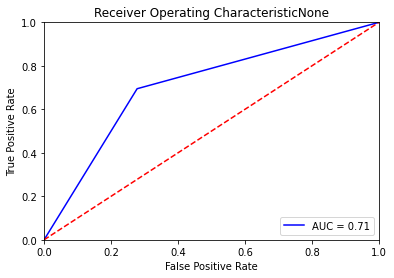

In [20]:
#Training and Testing Catboost model

modelL = create_model('catboost')
plotModel(modelL, X_test, y_test)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7799,0.8764,0.7688,0.8580,0.8110,0.5494,0.5542
1,0.7943,0.8861,0.7911,0.8625,0.8252,0.5763,0.5795
2,0.8079,0.8966,0.8122,0.8666,0.8385,0.6021,0.6041
3,0.7848,0.8754,0.7785,0.8579,0.8163,0.5580,0.5618
4,0.7971,0.8839,0.7871,0.8700,0.8265,0.5836,0.5878
5,0.7931,0.8839,0.7865,0.8645,0.8237,0.5748,0.5786
6,0.8058,0.8927,0.8127,0.8629,0.8371,0.5971,0.5988
7,0.7858,0.8753,0.7830,0.8558,0.8178,0.5591,0.5624
8,0.7949,0.8873,0.8081,0.8504,0.8287,0.5735,0.5747
9,0.8005,0.8837,0.8127,0.8552,0.8334,0.5852,0.5864


[[5850 2851]
 [ 314  836]]
0.7269565217391304


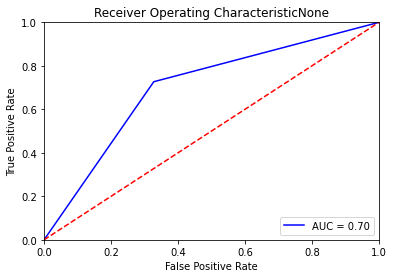

<catboost.core.CatBoostClassifier object at 0x7f63d0916910> <catboost.core.CatBoostClassifier object at 0x7f63d1a6cd00>


In [21]:
#Tuning and Evaluating Catboost model

tunedModelL = tune_model(modelL, optimize = 'AUC')
plotModel(tunedModelL, X_test, y_test)
print(modelL, tunedModelL)

In [23]:
print(modelL.get_params(), '\n',tunedModelL.get_params())

{'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 7214} 
 {'depth': 9, 'l2_leaf_reg': 3, 'border_count': 254, 'verbose': False, 'random_strength': 0.0, 'task_type': 'CPU', 'n_estimators': 200, 'random_state': 7214}


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7942,0.8871,0.7906,0.8641,0.8257,0.5758,0.5792
1,0.7858,0.8827,0.7809,0.8588,0.8180,0.5591,0.5628
2,0.7883,0.8868,0.7941,0.8524,0.8222,0.5613,0.5634
3,0.7833,0.8848,0.7889,0.8490,0.8179,0.5514,0.5536
4,0.7911,0.8803,0.7888,0.8605,0.8231,0.5691,0.5723
5,0.7833,0.8724,0.7700,0.8636,0.8141,0.5562,0.5615
6,0.8026,0.8920,0.7979,0.8710,0.8329,0.5929,0.5963
7,0.7854,0.8790,0.7877,0.8529,0.8190,0.5564,0.5591
8,0.8040,0.8859,0.8025,0.8695,0.8347,0.5950,0.5979
9,0.7920,0.8834,0.7814,0.8681,0.8225,0.5732,0.5778


[[6096 2605]
 [ 310  840]]
0.7304347826086957


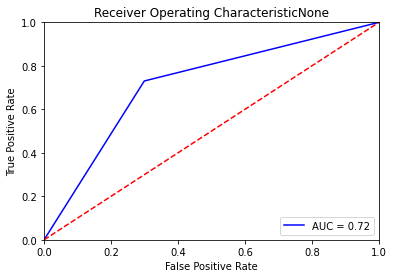

In [13]:
#Training and Evaluation

tmp = trainPlotWrapper('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7942,0.8873,0.7849,0.8687,0.8247,0.5772,0.5815
1,0.7826,0.8836,0.7775,0.8567,0.8152,0.5528,0.5567
2,0.7904,0.8852,0.7946,0.8551,0.8238,0.5659,0.5683
3,0.7816,0.8830,0.7832,0.8507,0.8156,0.5489,0.5517
4,0.7921,0.8783,0.7803,0.8690,0.8223,0.5737,0.5785
5,0.7815,0.8740,0.7626,0.8670,0.8114,0.5542,0.5607
6,0.8026,0.8901,0.7939,0.8743,0.8322,0.5939,0.5980
7,0.7833,0.8767,0.7860,0.8511,0.8172,0.5520,0.5547
8,0.8058,0.8845,0.7934,0.8797,0.8343,0.6011,0.6058
9,0.7928,0.8828,0.7882,0.8637,0.8242,0.5730,0.5766


[[6114 2587]
 [ 307  843]]
0.7330434782608696


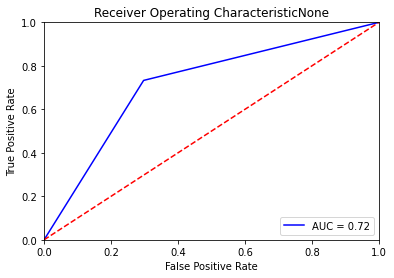

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8331, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) 
 LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.282, max_depth=-1,
               min_child_samples=10, min_child_weight=0.001, min_split_gain=0.8,
               n_estimators=120, n_jobs=-1, num_leaves=50, objective=None,
               random_state=8331, reg_alpha=0.05, reg_lambda=0.0001,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               su

In [14]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7907,0.8828,0.7941,0.8561,0.8239,0.5669,0.5693
1,0.7858,0.8833,0.7901,0.8518,0.8198,0.5567,0.5591
2,0.7914,0.8854,0.8009,0.8519,0.8256,0.5667,0.5684
3,0.7868,0.8835,0.8026,0.8440,0.8228,0.5558,0.5569
4,0.7914,0.8787,0.7882,0.8615,0.8232,0.5701,0.5734
5,0.7811,0.8701,0.7774,0.8545,0.8141,0.5495,0.5531
6,0.7998,0.8904,0.8031,0.8627,0.8318,0.5853,0.5876
7,0.7868,0.8783,0.7985,0.8469,0.8220,0.5568,0.5583
8,0.7994,0.8824,0.7979,0.8662,0.8307,0.5858,0.5887
9,0.7892,0.8809,0.7951,0.8530,0.8230,0.5633,0.5654


[[5962 2739]
 [ 302  848]]
0.7373913043478261


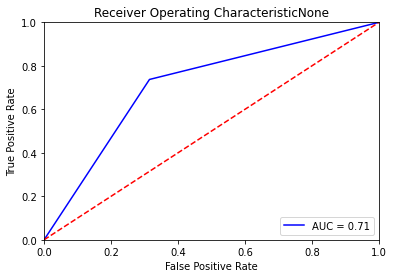

In [15]:
#Training and Evaluation

tmp = trainPlotWrapper('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7450,0.8675,0.6104,0.9622,0.7469,0.5146,0.5698
1,0.7362,0.8649,0.5978,0.9588,0.7365,0.4994,0.5563
2,0.7605,0.8689,0.6440,0.9519,0.7683,0.5387,0.5835
3,0.7460,0.8701,0.6092,0.9665,0.7474,0.5172,0.5738
4,0.7309,0.8607,0.5947,0.9499,0.7315,0.4890,0.5438
5,0.7516,0.8611,0.6204,0.9637,0.7549,0.5259,0.5792
6,0.7488,0.8722,0.6170,0.9617,0.7517,0.5209,0.5744
7,0.7322,0.8605,0.5959,0.9517,0.7329,0.4915,0.5466
8,0.7463,0.8651,0.6124,0.9623,0.7485,0.5168,0.5715
9,0.7488,0.8641,0.6210,0.9561,0.7529,0.5198,0.5707


[[7147 1554]
 [ 435  715]]
0.6217391304347826


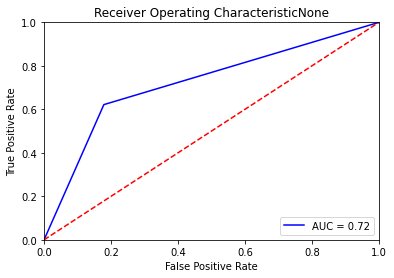

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=8331, verbose=0,
                       warm_start=False) 
 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features=1.0, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=

In [16]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7904,0.8804,0.7912,0.8578,0.8231,0.5668,0.5696
1,0.7851,0.8823,0.7878,0.8525,0.8189,0.5557,0.5583
2,0.7897,0.8832,0.7992,0.8506,0.8241,0.5632,0.5649
3,0.7868,0.8821,0.8003,0.8457,0.8224,0.5564,0.5577
4,0.7897,0.8758,0.7860,0.8606,0.8216,0.5667,0.5701
5,0.7787,0.8676,0.7648,0.8606,0.8099,0.5473,0.5527
6,0.8005,0.8892,0.8031,0.8637,0.8323,0.5869,0.5893
7,0.7868,0.8768,0.7951,0.8494,0.8213,0.5577,0.5595
8,0.8008,0.8805,0.7968,0.8692,0.8314,0.5892,0.5926
9,0.7906,0.8792,0.7934,0.8564,0.8237,0.5669,0.5695


[[6021 2680]
 [ 315  835]]
0.7260869565217392


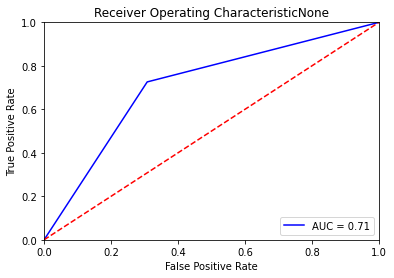

In [17]:
#Training and Evaluation

tmp = trainPlotWrapper('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7619,0.8620,0.7433,0.8516,0.7938,0.5151,0.5218
1,0.7569,0.8584,0.7085,0.8734,0.7824,0.5139,0.5284
2,0.7541,0.8592,0.7188,0.8595,0.7829,0.5046,0.5154
3,0.7601,0.8624,0.7410,0.8507,0.7921,0.5118,0.5186
4,0.7460,0.8479,0.7163,0.8480,0.7766,0.4872,0.4965
5,0.7540,0.8474,0.7192,0.8589,0.7829,0.5044,0.5150
6,0.7643,0.8655,0.6855,0.9098,0.7819,0.5362,0.5619
7,0.7544,0.8572,0.7078,0.8696,0.7804,0.5084,0.5223
8,0.7576,0.8548,0.7626,0.8303,0.7950,0.4997,0.5024
9,0.7646,0.8584,0.7112,0.8843,0.7884,0.5301,0.5462


[[6186 2515]
 [ 364  786]]
0.6834782608695652


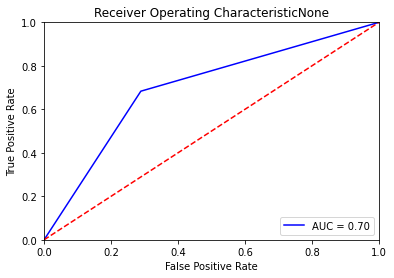

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=8331, verbose=0,
                     warm_start=False) 
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='entropy',
                     max_depth=9, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=2,
                     min_samples_split=5, min_weight_fraction_leaf=0.0,
                     n_estimators=10, n_jobs=-1, oob_score=Fals

In [18]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7921,0.8796,0.7924,0.8595,0.8246,0.5705,0.5734
1,0.7833,0.8797,0.7844,0.8524,0.8170,0.5526,0.5555
2,0.7911,0.8841,0.7992,0.8527,0.8251,0.5664,0.5682
3,0.7865,0.8795,0.8015,0.8444,0.8224,0.5553,0.5565
4,0.7897,0.8753,0.7848,0.8615,0.8214,0.5670,0.5706
5,0.7804,0.8683,0.7671,0.8615,0.8116,0.5506,0.5560
6,0.8030,0.8913,0.8048,0.8661,0.8343,0.5921,0.5945
7,0.7871,0.8771,0.7945,0.8503,0.8215,0.5586,0.5606
8,0.8012,0.8800,0.7979,0.8689,0.8319,0.5897,0.5930
9,0.7892,0.8768,0.7922,0.8552,0.8225,0.5640,0.5665


[[6012 2689]
 [ 311  839]]
0.7295652173913043


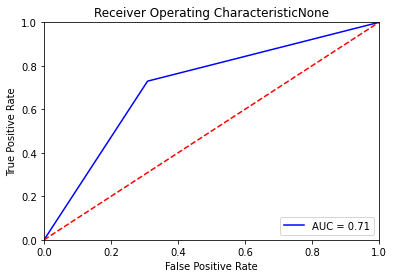

In [19]:
#Training and Evaluation

tmp = trainPlotWrapper('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7721,0.8678,0.8106,0.8181,0.8143,0.5193,0.5193
1,0.7742,0.8614,0.8049,0.8247,0.8147,0.5258,0.5261
2,0.7668,0.8643,0.8169,0.8072,0.8120,0.5050,0.5050
3,0.7795,0.8739,0.8260,0.8181,0.8220,0.5322,0.5322
4,0.7738,0.8596,0.8122,0.8192,0.8157,0.5230,0.5231
5,0.7699,0.8607,0.8088,0.8162,0.8125,0.5147,0.5147
6,0.7783,0.8730,0.8196,0.8206,0.8201,0.5314,0.5314
7,0.7678,0.8606,0.8276,0.8020,0.8146,0.5041,0.5045
8,0.7738,0.8622,0.8099,0.8207,0.8153,0.5234,0.5235
9,0.7671,0.8632,0.8031,0.8161,0.8096,0.5098,0.5099


[[5451 3250]
 [ 288  862]]
0.7495652173913043


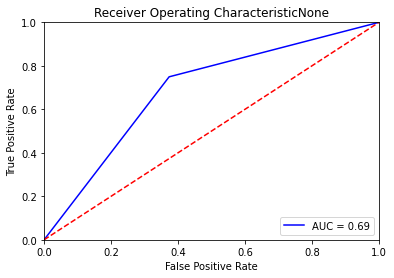

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=8331, splitter='best') 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=8331, splitter='best')


In [20]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7809,0.8818,0.8129,0.8285,0.8206,0.5392,0.5393
1,0.7809,0.8748,0.7809,0.8514,0.8146,0.5479,0.5510
2,0.7805,0.8800,0.7963,0.8394,0.8173,0.5429,0.5441
3,0.7816,0.8779,0.7906,0.8451,0.8170,0.5469,0.5488
4,0.7854,0.8740,0.7705,0.8665,0.8157,0.5611,0.5666
5,0.7752,0.8685,0.7694,0.8515,0.8084,0.5380,0.5421
6,0.7931,0.8833,0.7820,0.8693,0.8233,0.5754,0.5801
7,0.7755,0.8695,0.8139,0.8205,0.8172,0.5264,0.5264
8,0.7984,0.8812,0.8002,0.8628,0.8303,0.5828,0.5853
9,0.7801,0.8766,0.7991,0.8368,0.8175,0.5412,0.5421


[[5952 2749]
 [ 301  849]]
0.7382608695652174


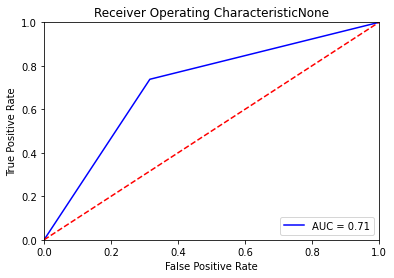

In [21]:
#Training and Evaluation

tmp = trainPlotWrapper('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7942,0.8861,0.7798,0.8729,0.8237,0.5785,0.5838
1,0.7844,0.8822,0.7673,0.8677,0.8144,0.5595,0.5655
2,0.7879,0.8853,0.7735,0.8681,0.8181,0.5658,0.5712
3,0.7837,0.8816,0.7655,0.8680,0.8136,0.5583,0.5646
4,0.7911,0.8788,0.7803,0.8674,0.8215,0.5713,0.5760
5,0.7811,0.8710,0.7603,0.8683,0.8107,0.5540,0.5609
6,0.7991,0.8897,0.7894,0.8726,0.8289,0.5871,0.5914
7,0.7847,0.8779,0.7768,0.8603,0.8164,0.5576,0.5619
8,0.8019,0.8856,0.7934,0.8737,0.8316,0.5924,0.5965
9,0.7917,0.8824,0.7814,0.8676,0.8222,0.5724,0.5770


[[6156 2545]
 [ 320  830]]
0.7217391304347827


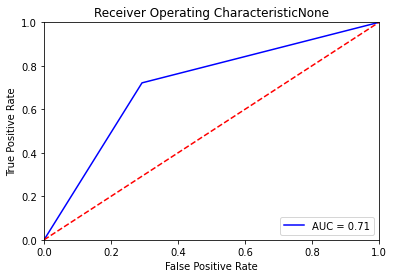

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8331, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.49, loss='deviance', max_depth=3,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.001, min_impurity_split=None

In [22]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7759,0.8700,0.8169,0.8192,0.8181,0.5265,0.5265
1,0.7700,0.8616,0.8112,0.8149,0.8130,0.5141,0.5141
2,0.7710,0.8688,0.8192,0.8113,0.8152,0.5143,0.5143
3,0.7735,0.8684,0.8192,0.8145,0.8168,0.5201,0.5201
4,0.7756,0.8582,0.8162,0.8190,0.8176,0.5260,0.5260
5,0.7643,0.8564,0.8470,0.7869,0.8158,0.4896,0.4922
6,0.7829,0.8688,0.8191,0.8271,0.8231,0.5422,0.5423
7,0.7653,0.8579,0.8151,0.8063,0.8107,0.5020,0.5021
8,0.7671,0.8675,0.8362,0.7962,0.8157,0.4998,0.5009
9,0.7762,0.8671,0.8094,0.8244,0.8168,0.5294,0.5295


[[5428 3273]
 [ 278  872]]
0.7582608695652174


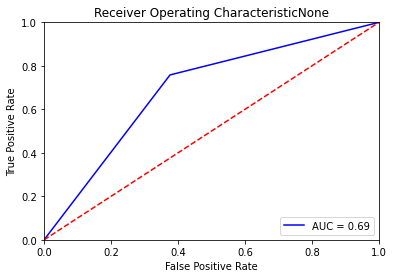

In [23]:
#Training and Evaluation

tmp = trainPlotWrapper('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7763,0.8738,0.8175,0.8193,0.8184,0.5272,0.5272
1,0.7724,0.8674,0.8152,0.8156,0.8154,0.5188,0.5188
2,0.7731,0.8737,0.8260,0.8098,0.8178,0.5172,0.5174
3,0.7749,0.8726,0.8226,0.8142,0.8184,0.5224,0.5224
4,0.7784,0.8645,0.8145,0.8239,0.8192,0.5331,0.5332
5,0.7741,0.8622,0.8065,0.8234,0.8149,0.5252,0.5254
6,0.7836,0.8755,0.8225,0.8258,0.8241,0.5429,0.5429
7,0.7678,0.8622,0.8179,0.8078,0.8128,0.5070,0.5071
8,0.7818,0.8728,0.8236,0.8227,0.8232,0.5385,0.5385
9,0.7759,0.8706,0.8134,0.8213,0.8173,0.5274,0.5274


[[5383 3318]
 [ 263  887]]
0.7713043478260869


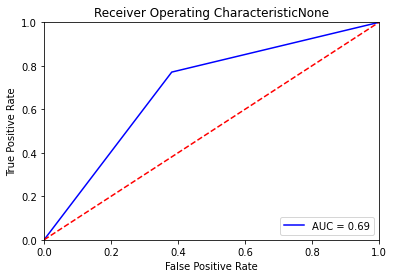

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=8331) 
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.44,
                   n_estimators=280, random_state=8331)


In [24]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7457,0.8351,0.8340,0.7719,0.8018,0.4486,0.4513
1,0.7559,0.8521,0.8078,0.7986,0.8032,0.4819,0.4820
2,0.7577,0.8482,0.7878,0.8133,0.8003,0.4923,0.4927
3,0.7569,0.8515,0.8682,0.7679,0.8150,0.4647,0.4722
4,0.7541,0.8464,0.7329,0.8475,0.7860,0.5006,0.5080
5,0.7273,0.8271,0.8059,0.7645,0.7847,0.4137,0.4147
6,0.7628,0.8438,0.7728,0.8307,0.8007,0.5089,0.5109
7,0.7643,0.8493,0.7939,0.8182,0.8059,0.5059,0.5063
8,0.7787,0.8423,0.7694,0.8570,0.8108,0.5460,0.5507
9,0.7519,0.8411,0.7340,0.8433,0.7849,0.4953,0.5019


[[5505 3196]
 [ 322  828]]
0.72


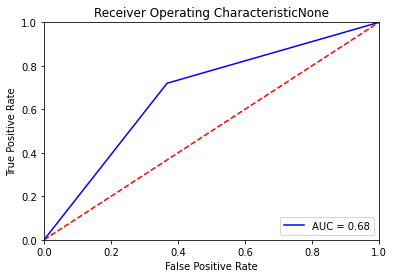

In [25]:
#Training and Evaluation

tmp = trainPlotWrapper('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7830,0.8734,0.7975,0.8422,0.8192,0.5483,0.5496
1,0.7770,0.8761,0.7513,0.8693,0.8060,0.5470,0.5551
2,0.7795,0.8741,0.8089,0.8292,0.8189,0.5370,0.5373
3,0.7847,0.8763,0.7986,0.8439,0.8206,0.5520,0.5533
4,0.7791,0.8685,0.7426,0.8802,0.8056,0.5541,0.5649
5,0.7664,0.8565,0.7888,0.8246,0.8063,0.5123,0.5131
6,0.7875,0.8803,0.7723,0.8684,0.8175,0.5652,0.5708
7,0.7843,0.8720,0.8122,0.8336,0.8228,0.5474,0.5477
8,0.7787,0.8695,0.7534,0.8701,0.8076,0.5503,0.5582
9,0.7794,0.8692,0.7591,0.8664,0.8092,0.5504,0.5571


[[6456 2245]
 [ 356  794]]
0.6904347826086956


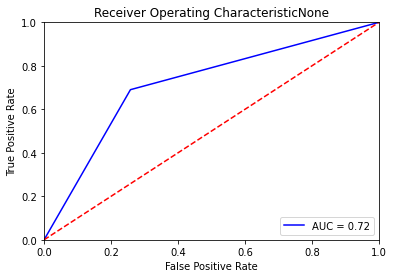

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform') 
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=43, p=2,
                     weights='distance')


In [26]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7467,0.8099,0.8465,0.7669,0.8048,0.4469,0.4513
1,0.7397,0.8024,0.8443,0.7601,0.8000,0.4303,0.4352
2,0.7489,0.8146,0.8671,0.7596,0.8098,0.4449,0.4535
3,0.7499,0.8135,0.8557,0.7661,0.8084,0.4516,0.4573
4,0.7425,0.8058,0.8442,0.7632,0.8016,0.4375,0.4421
5,0.7379,0.8100,0.8339,0.7629,0.7968,0.4295,0.4329
6,0.7484,0.8197,0.8487,0.7677,0.8062,0.4503,0.4550
7,0.7400,0.8012,0.8505,0.7575,0.8013,0.4288,0.4349
8,0.7460,0.8084,0.8499,0.7644,0.8049,0.4439,0.4490
9,0.7558,0.8186,0.8545,0.7732,0.8118,0.4666,0.4713


[[4414 4287]
 [ 271  879]]
0.7643478260869565


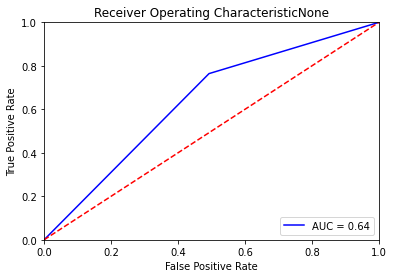

In [27]:
#Training and Evaluation

tmp = trainPlotWrapper('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7464,0.8099,0.8460,0.7668,0.8044,0.4462,0.4506
1,0.7397,0.8026,0.8443,0.7601,0.8000,0.4303,0.4352
2,0.7489,0.8146,0.8671,0.7596,0.8098,0.4449,0.4535
3,0.7499,0.8134,0.8557,0.7661,0.8084,0.4516,0.4573
4,0.7425,0.8058,0.8442,0.7632,0.8016,0.4375,0.4421
5,0.7379,0.8100,0.8339,0.7629,0.7968,0.4295,0.4329
6,0.7484,0.8197,0.8487,0.7677,0.8062,0.4503,0.4550
7,0.7400,0.8012,0.8505,0.7575,0.8013,0.4288,0.4349
8,0.7456,0.8084,0.8493,0.7643,0.8045,0.4432,0.4483
9,0.7558,0.8186,0.8545,0.7732,0.8118,0.4666,0.4713


[[4414 4287]
 [ 271  879]]
0.7643478260869565


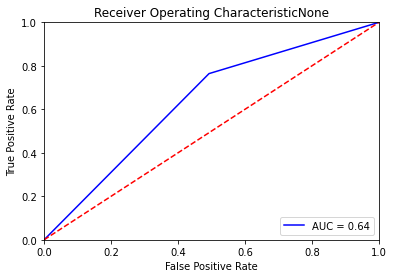

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001) 
 LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.0001,
                           solver='lsqr', store_covariance=False, tol=0.0001)


In [28]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7474,0.8107,0.8363,0.7728,0.8033,0.4522,0.4549
1,0.7387,0.7957,0.8351,0.7633,0.7976,0.4310,0.4344
2,0.7503,0.8040,0.8574,0.7657,0.8089,0.4518,0.4579
3,0.7482,0.8124,0.8517,0.7660,0.8066,0.4486,0.4538
4,0.7474,0.8050,0.8362,0.7727,0.8032,0.4524,0.4552
5,0.7403,0.7950,0.8265,0.7694,0.7969,0.4382,0.4404
6,0.7491,0.8074,0.8390,0.7733,0.8048,0.4554,0.4584
7,0.7386,0.7872,0.8356,0.7629,0.7976,0.4307,0.4342
8,0.7463,0.7954,0.8408,0.7692,0.8034,0.4479,0.4514
9,0.7530,0.8202,0.8430,0.7757,0.8080,0.4635,0.4667


[[4563 4138]
 [ 277  873]]
0.7591304347826087


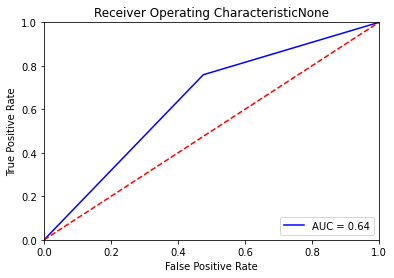

In [29]:
#Training and Evaluation

tmp = trainPlotWrapper('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7464,0.7981,0.7975,0.7925,0.7950,0.4626,0.4626
1,0.7404,0.8042,0.7958,0.7859,0.7908,0.4489,0.4489
2,0.7450,0.8161,0.8140,0.7815,0.7974,0.4537,0.4544
3,0.7464,0.8135,0.8026,0.7896,0.7960,0.4609,0.4610
4,0.7453,0.8049,0.7905,0.7951,0.7928,0.4625,0.4625
5,0.7393,0.7951,0.7860,0.7900,0.7880,0.4495,0.4495
6,0.7407,0.8074,0.7934,0.7875,0.7904,0.4504,0.4504
7,0.7382,0.7870,0.8014,0.7800,0.7905,0.4417,0.4420
8,0.7407,0.7948,0.7945,0.7869,0.7907,0.4500,0.4500
9,0.7477,0.8205,0.8002,0.7925,0.7964,0.4649,0.4649


[[5105 3596]
 [ 328  822]]
0.7147826086956521


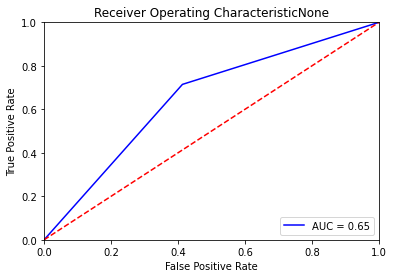

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8331, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 
 LogisticRegression(C=9.53, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8331, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [30]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7000,0.7976,0.9293,0.6908,0.7925,0.2910,0.3367
1,0.6943,0.7894,0.9355,0.6845,0.7906,0.2723,0.3232
2,0.7116,0.8049,0.9344,0.6991,0.7998,0.3204,0.3673
3,0.6957,0.7997,0.9218,0.6894,0.7889,0.2830,0.3246
4,0.6954,0.8018,0.9218,0.6890,0.7886,0.2825,0.3242
5,0.6985,0.8056,0.9235,0.6912,0.7906,0.2898,0.3320
6,0.7238,0.8191,0.6290,0.8909,0.7374,0.4637,0.4954
7,0.6925,0.7964,0.9189,0.6874,0.7865,0.2756,0.3159
8,0.7104,0.7974,0.9281,0.7000,0.7980,0.3203,0.3633
9,0.7065,0.8077,0.9321,0.6955,0.7966,0.3079,0.3543


[[2525 6176]
 [ 162  988]]
0.8591304347826086


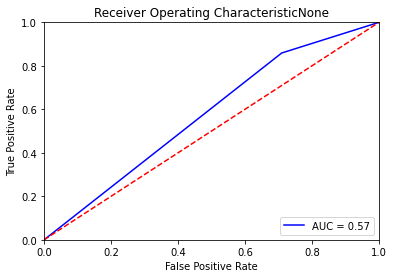

In [31]:
#Training and Evaluation

tmp = trainPlotWrapper('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7411,0.8047,0.8038,0.7823,0.7929,0.4479,0.4482
1,0.7334,0.7944,0.8072,0.7711,0.7887,0.4280,0.4288
2,0.7517,0.8097,0.8237,0.7844,0.8036,0.4666,0.4677
3,0.7450,0.8063,0.8186,0.7790,0.7983,0.4522,0.4532
4,0.7446,0.8048,0.8037,0.7866,0.7950,0.4565,0.4567
5,0.7417,0.8121,0.8048,0.7825,0.7935,0.4491,0.4494
6,0.7424,0.8211,0.8054,0.7830,0.7940,0.4506,0.4509
7,0.7393,0.7971,0.8122,0.7755,0.7934,0.4406,0.4414
8,0.7365,0.8033,0.8094,0.7736,0.7911,0.4347,0.4355
9,0.7460,0.8152,0.8116,0.7839,0.7975,0.4569,0.4574


[[4834 3867]
 [ 285  865]]
0.7521739130434782


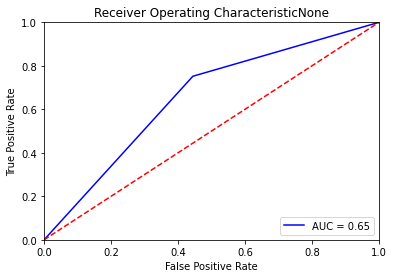

GaussianNB(priors=None, var_smoothing=1e-09) 
 GaussianNB(priors=None, var_smoothing=0.006)


In [32]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5019,0.0000,0.1940,0.9913,0.3244,0.1536,0.2854
1,0.7313,0.0000,0.8465,0.7499,0.7953,0.4084,0.4148
2,0.7492,0.0000,0.8671,0.7600,0.8100,0.4458,0.4543
3,0.5142,0.0000,0.2133,0.9947,0.3513,0.1707,0.3036
4,0.7436,0.0000,0.8288,0.7719,0.7993,0.4455,0.4476
5,0.7382,0.0000,0.8316,0.7644,0.7966,0.4312,0.4342
6,0.6267,0.0000,0.9994,0.6229,0.7675,0.0330,0.1262
7,0.7382,0.0000,0.8231,0.7687,0.7949,0.4342,0.4362
8,0.7340,0.0000,0.8071,0.7718,0.7891,0.4295,0.4303
9,0.7347,0.0000,0.9001,0.7314,0.8071,0.3967,0.4192


[[4440 4261]
 [ 256  894]]
0.7773913043478261


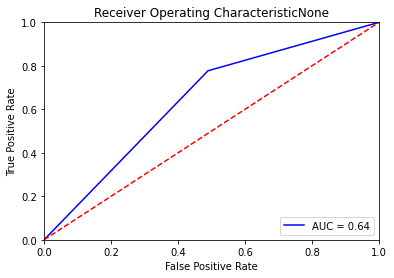

In [33]:
#Training and Evaluation

tmp = trainPlotWrapper('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6240,0.0000,1.0000,0.6212,0.7663,0.0237,0.1094
1,0.6254,0.0000,0.9989,0.6222,0.7668,0.0290,0.1143
2,0.6430,0.0000,0.9880,0.6354,0.7734,0.0915,0.1863
3,0.6310,0.0000,0.9983,0.6259,0.7694,0.0472,0.1474
4,0.3837,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.3835,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6165,0.0000,1.0000,0.6165,0.7627,0.0000,0.0000
7,0.6288,0.0000,0.9966,0.6247,0.7680,0.0417,0.1304
8,0.6481,0.0000,0.6758,0.7327,0.7031,0.2730,0.2744
9,0.6232,0.0000,1.0000,0.6206,0.7659,0.0214,0.1040


[[8701    0]
 [1150    0]]
0.0


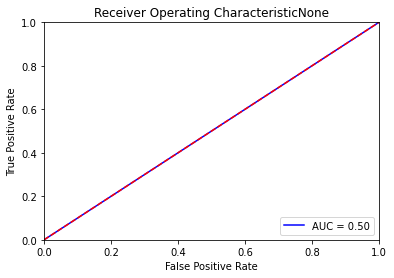

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=8331, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 
 SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.05, fit_intercept=False,
              l1_ratio=0.6800000001, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=8331, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [34]:
#Tuning and Evaluation

TunePlotWrapper(tmp)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7478,0.0000,0.8483,0.7673,0.8057,0.4489,0.4535
1,0.7404,0.0000,0.8465,0.7599,0.8009,0.4312,0.4365
2,0.7485,0.0000,0.8671,0.7592,0.8096,0.4441,0.4526
3,0.7513,0.0000,0.8597,0.7658,0.8100,0.4537,0.4600
4,0.7425,0.0000,0.8442,0.7632,0.8016,0.4375,0.4421
5,0.7379,0.0000,0.8345,0.7626,0.7969,0.4293,0.4328
6,0.7484,0.0000,0.8493,0.7674,0.8063,0.4501,0.4549
7,0.7400,0.0000,0.8516,0.7570,0.8015,0.4284,0.4347
8,0.7467,0.0000,0.8510,0.7646,0.8055,0.4452,0.4505
9,0.7548,0.0000,0.8562,0.7712,0.8115,0.4634,0.4686


[[4400 4301]
 [ 270  880]]
0.7652173913043478


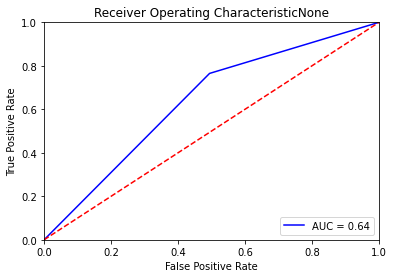

In [35]:
#Training and Evaluation

tmp = trainPlotWrapper('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7482,0.0000,0.8488,0.7674,0.8061,0.4496,0.4542
1,0.7394,0.0000,0.8465,0.7587,0.8002,0.4286,0.4340
2,0.7482,0.0000,0.8671,0.7589,0.8094,0.4432,0.4518
3,0.7506,0.0000,0.8602,0.7647,0.8097,0.4517,0.4583
4,0.7425,0.0000,0.8442,0.7632,0.8016,0.4375,0.4421
5,0.7375,0.0000,0.8345,0.7623,0.7967,0.4285,0.4320
6,0.7484,0.0000,0.8493,0.7674,0.8063,0.4501,0.4549
7,0.7400,0.0000,0.8516,0.7570,0.8015,0.4284,0.4347
8,0.7463,0.0000,0.8505,0.7645,0.8052,0.4445,0.4497
9,0.7551,0.0000,0.8567,0.7713,0.8118,0.4641,0.4693


[[4410 4291]
 [ 270  880]]
0.7652173913043478


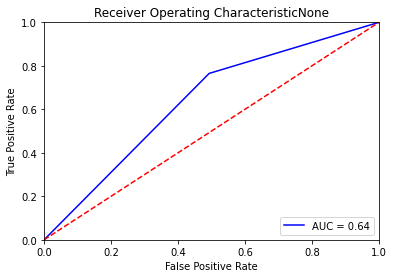

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=8331,
                solver='auto', tol=0.001) 
 RidgeClassifier(alpha=9.06, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=8331,
                solver='auto', tol=0.001)


In [36]:
#Tuning and Evaluation

TunePlotWrapper(tmp)